In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

# Part 2

In [2]:
spx = pd.read_csv('SPX_options.csv')

In [3]:
spy = pd.read_csv('SPY_options.csv')

In [4]:
interestrates = pd.read_csv('zero_rates_20201201.csv')

In [5]:
spy['exdate'].value_counts()

20210115    556
20201218    510
20210219    334
Name: exdate, dtype: int64

In [6]:
spx['exdate'].value_counts()

20201218    822
20210115    738
20210219    512
Name: exdate, dtype: int64

In [7]:
spx_exdate = pd.DataFrame(0, index = np.arange(0, 3), columns = ['days_to_expiry'])

for i in np.arange(0, 3):    
    spx_exdate['days_to_expiry'][i] = (pd.Timestamp(str(spx['exdate'].unique()[i])) - pd.Timestamp('2020-12-01')).days
    
spx_exdate

,days_to_expiry
0,17
1,45
2,80


In [8]:
spy_exdate = pd.DataFrame(0, index = np.arange(0, 3), columns = ['days_to_expiry'])

for i in np.arange(0, 3):    
    spy_exdate['days_to_expiry'][i] = (pd.Timestamp(str(spy['exdate'].unique()[i])) - pd.Timestamp('2020-12-01')).days
    
spy_exdate

,days_to_expiry
0,17
1,45
2,80


In [9]:
x = interestrates['days']
y = interestrates['rate']

In [10]:
fit = np.polyfit(x, y, deg = 16)

In [11]:
fit

array([-7.94209462e-51,  2.34407882e-46, -3.14929601e-42,  2.54950088e-38,
       -1.38751442e-34,  5.36289313e-31, -1.51620399e-27,  3.18214674e-24,
       -4.97995192e-21,  5.78772546e-18, -4.93358841e-15,  3.01695081e-12,
       -1.27773128e-09,  3.54673662e-07, -5.88926818e-05,  4.96713379e-03,
        6.67967090e-02])

In [12]:
spx_exdate.values

array([[17],
       [45],
       [80]])

In [13]:
interpolated_rates = np.polyval(fit, spx_exdate.values)
interpolated_rates

array([[0.13585796],
       [0.19865802],
       [0.22521736]])

In [14]:
def ir_interpolate(days_to_expiry):
    x = interestrates['days']
    y = interestrates['rate']
    fit = np.polyfit(x, y, deg = 16)
    
    rates = np.polyval(fit, days_to_expiry)
    
    return rates

In [15]:
def f(x):
    return np.polyval(fit, x)

In [16]:
days = np.linspace(0, 3500)

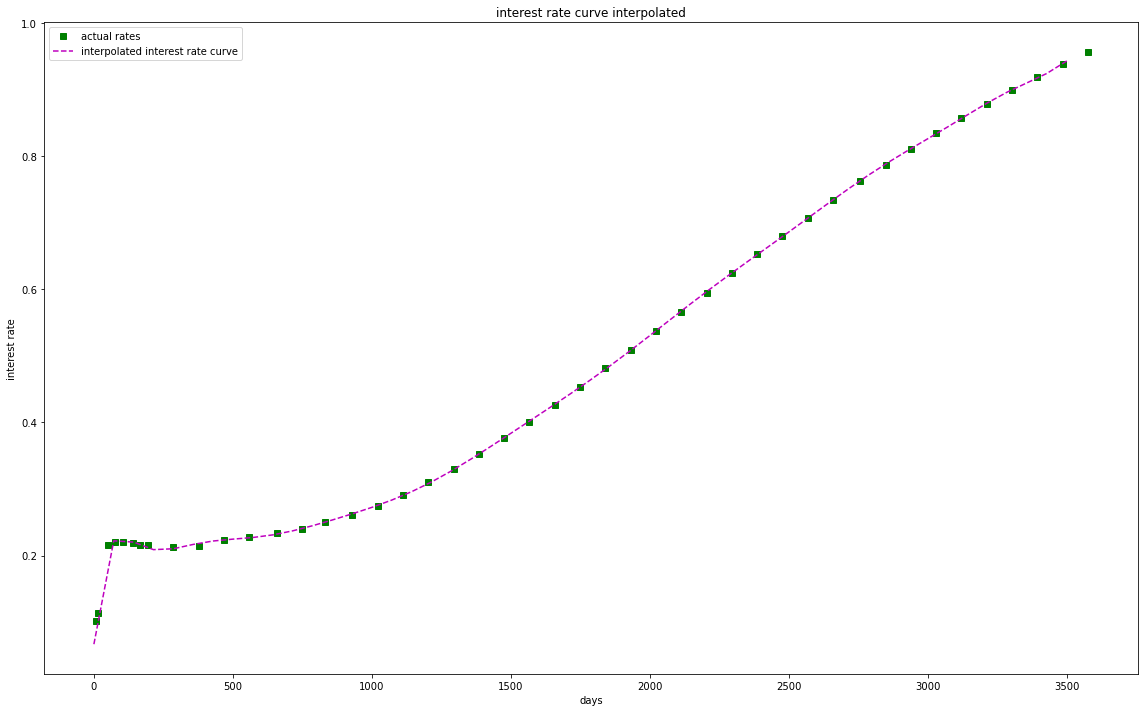

In [143]:
plt.figure(tight_layout=True, figsize = (16, 10))
plt.plot(interestrates['days'], interestrates['rate'], 'gs', label='actual rates')
plt.plot(days, f(days), 'm--', label='interpolated interest rate curve')
plt.xlabel('days')
plt.ylabel('interest rate')
plt.title('interest rate curve interpolated')
plt.legend()
plt.show()

## calibration of SABR model

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    # F represents F_0 in the formula above
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [19]:
def SABR_calibrate(exdate, df, S):

    beta = 0.7

    def sabrcalibration(x, strikes, vols, F, T):
        '''sum of squared errors using SABR model'''
        err = 0.0
        for i, vol in enumerate(vols):
            err += (vol - SABR(F, strikes[i], T,
                               x[0], beta, x[1], x[2]))**2

        return err


    def impliedVolatility(S, K, r, price, T, payoff):
        '''comparing market prices to BS prices to obtain implied vol'''
        try:
            if (payoff.lower() == 'call'):
                impliedVol = brentq(lambda x: price -
                                    BlackScholesLognormalCall(S, K, r, x, T),
                                    1e-12, 10.0)
            elif (payoff.lower() == 'put'):
                impliedVol = brentq(lambda x: price -
                                    BlackScholesLognormalPut(S, K, r, x, T),
                                    1e-12, 10.0)
            else:
                raise NameError('Payoff type not recognized')
        except Exception:
            impliedVol = np.nan

        return impliedVol


    def BlackScholesLognormalCall(S, K, r, sigma, T):
        d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


    def BlackScholesLognormalPut(S, K, r, sigma, T):
        d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


    #####
    # Here, load DataFrame with strike and implied volatility information into "df"
    #####
#     df = pd.read_csv('SPX_options.csv')
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001 # strike expressed in thousands, field practice?
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
#     exdate = sorted(df['exdate'].unique())[0] # earliest expiry date, but is the choice arbitrary?
    df = df[df['exdate'] == exdate]
    days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
    T = days_to_expiry/365
    r = ir_interpolate(days_to_expiry) / 100.0
    F = S*np.exp(r*T)

    # implied vol for all strikes
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                      x['strike'],
                                                      r,
                                                      x['mid'],
                                                      T,
                                                      x['payoff']),
                          axis=1)

    df.dropna(inplace=True)
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values # .values to convert series into an array of raw values
    # put_df contains all strikes, why?
    # possible to do strikes = sorted(df['strike'].unique()) instead?

    # because we only wish to observe vols of OTM options?
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) # why is [0] necessary?
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

    # cannot simply get vols from df because on some strikes there are both call and put

    # populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

    initialGuess = [0.02, 0.2, 0.1] # initial guess for alpha rho and nu
    # any guide for initial guess?

    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    # least_squares(function_giving_residuals, initial_guess)

    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

    # obtain SABR vols using calibrated parameters
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    # visualize 
    plt.figure(tight_layout=True, figsize = (16, 10))
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.xlabel('strike')
    plt.ylabel('volatility')
    plt.title("Implied Volatility Term Structure Calibration using SABR model w " + str(days_to_expiry) + " days to expiry")
    plt.legend()
    plt.show()

In [20]:
S_spx = 3662.45
S_spy = 366.02

## SPX

Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


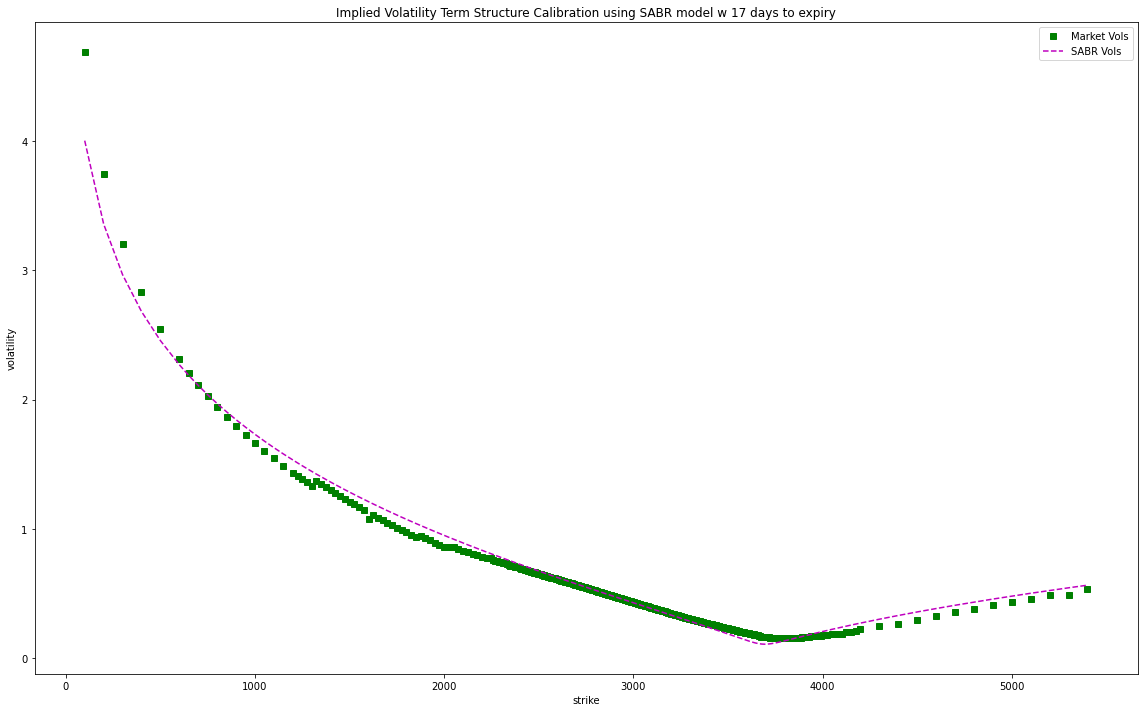

In [21]:
SABR_calibrate(spx['exdate'].unique()[0], spx, S_spx)

Calibrated SABR model parameters: alpha = 1.816, beta = 0.7, rho = -0.404, nu = 2.790


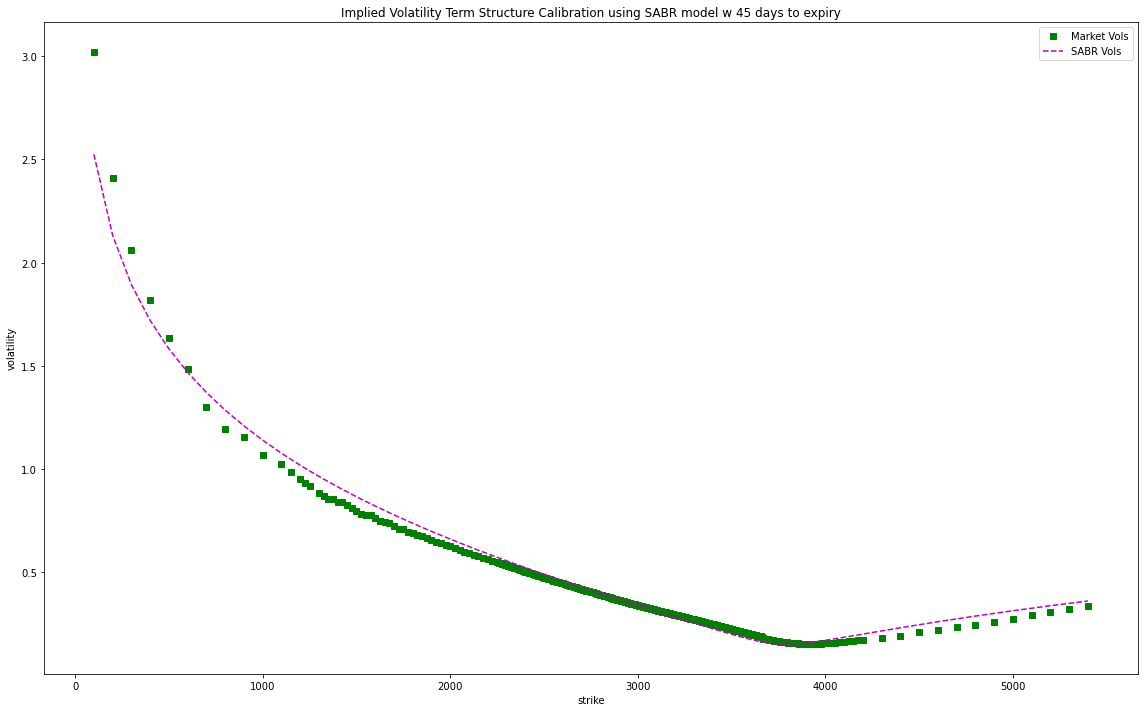

In [22]:
SABR_calibrate(spx['exdate'].unique()[1], spx, S_spx)

Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


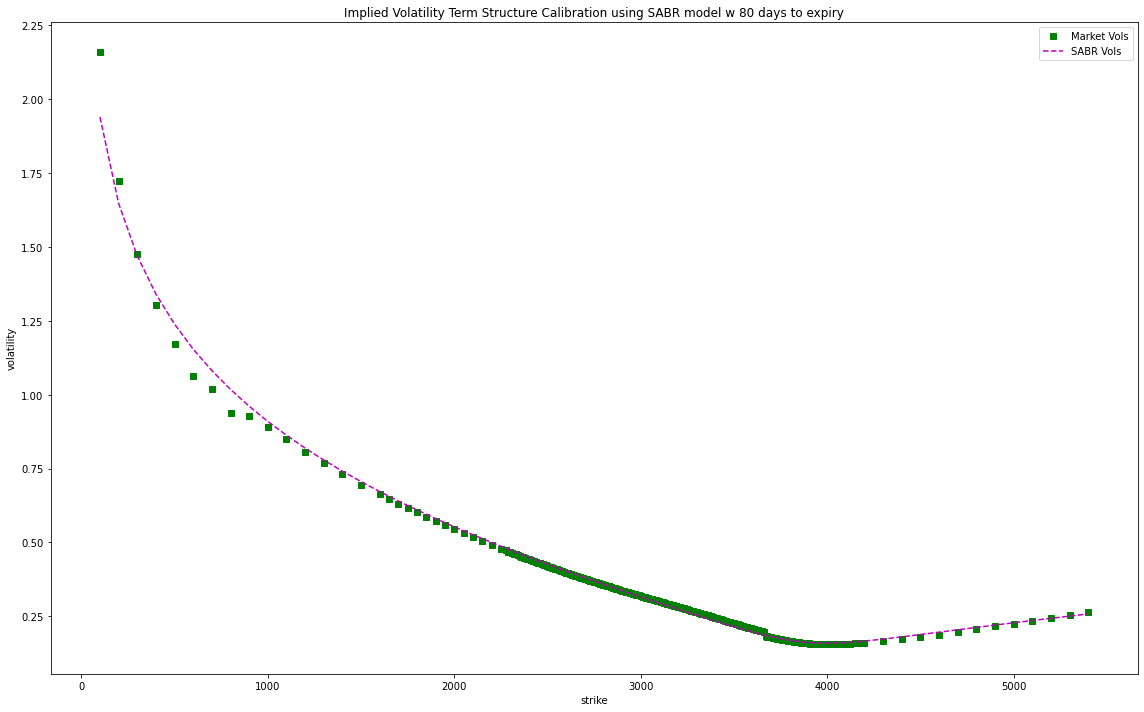

In [23]:
SABR_calibrate(spx['exdate'].unique()[2], spx, S_spx)

## SPY

Calibrated SABR model parameters: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250


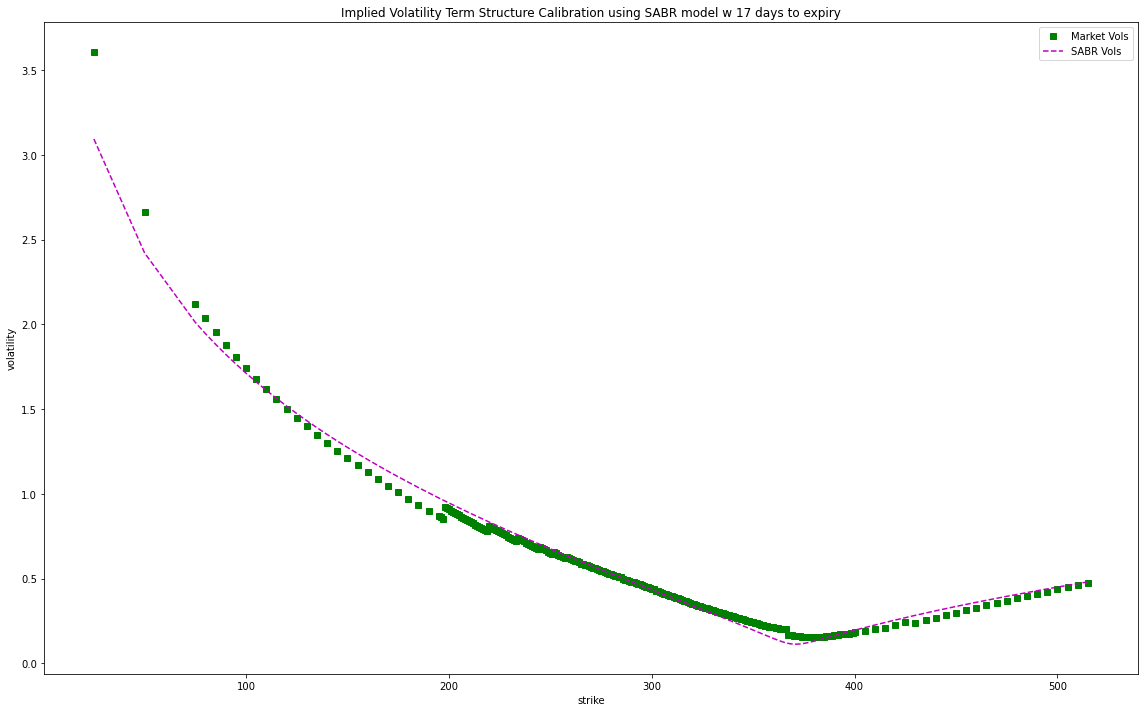

In [24]:
SABR_calibrate(spy['exdate'].unique()[0], spy, S_spy)

Calibrated SABR model parameters: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


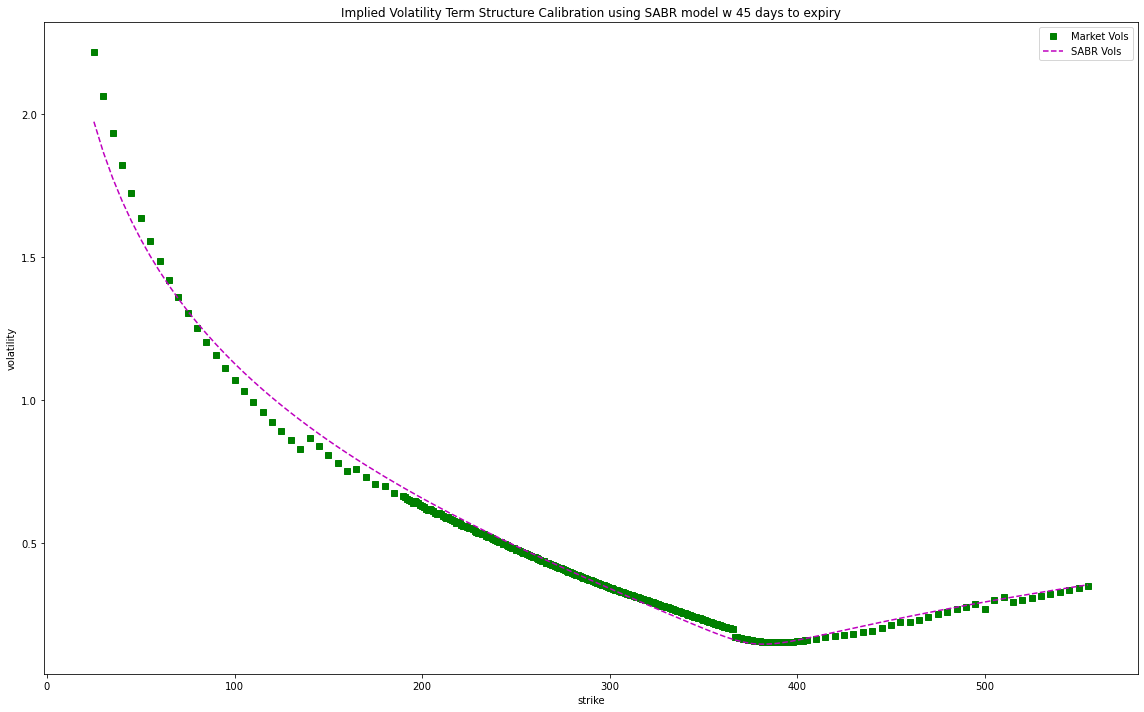

In [25]:
SABR_calibrate(spy['exdate'].unique()[1], spy, S_spy)

Calibrated SABR model parameters: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


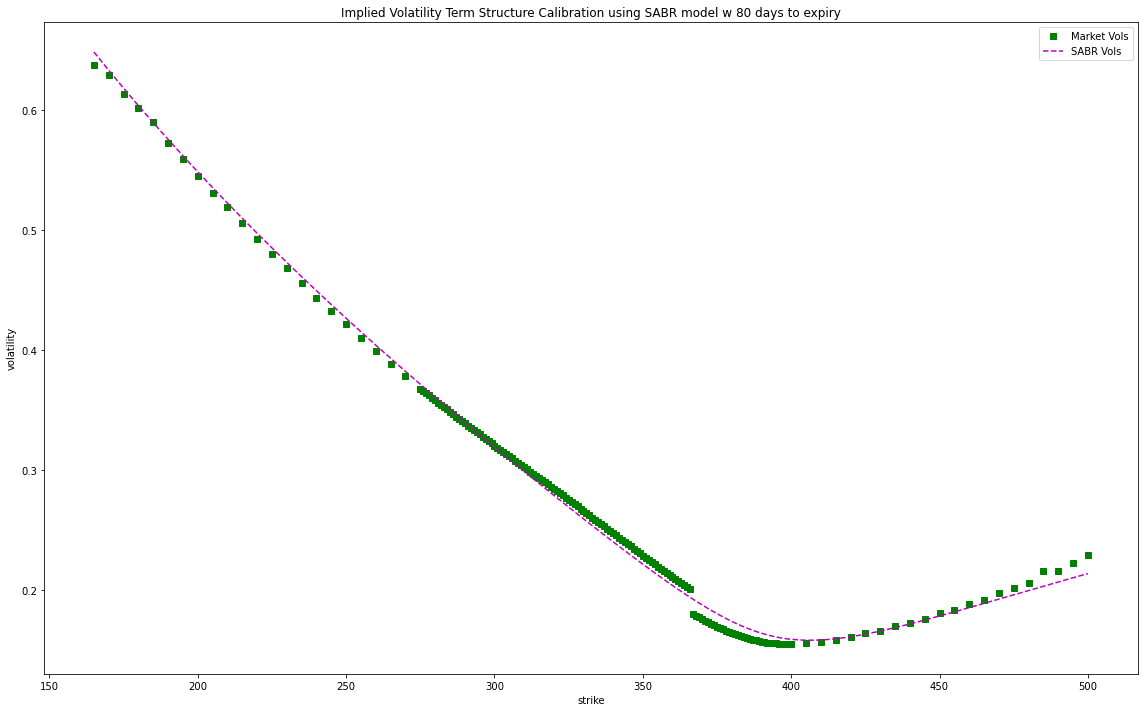

In [26]:
SABR_calibrate(spy['exdate'].unique()[2], spy, S_spy)

# Displaced-diffusion calibration

## Scenario 1: Calibrated beta obtained from minimizing SSE between DD IV and market IV

In [27]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import brentq, curve_fit, least_squares
from scipy.stats import norm

from math import log, exp, sqrt

In [28]:
from datetime import datetime

def impliedVolatility(S, K, r, price, T, payoff):
    '''comparing market prices to BS prices to obtain implied vol'''
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

spx['date'] = spx['date'] \
                      .apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
spx['exdate'] = spx['exdate'] \
                      .apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))


spx['tstep'] = (spx['exdate'] - spx['date']).dt.days.astype('int64')/365

spx['rates'] = np.where(spx['tstep'] == (17/365), 0.0013585796, np.nan)
spx['rates'] = np.where(spx['tstep'] == (45/365), 0.00198658026, spx['rates'])
spx['rates'] = np.where(spx['tstep'] == (80/365), 0.0022521736, spx['rates'])


spy['date'] = spy['date'] \
                      .apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
spy['exdate'] = spy['exdate'] \
                      .apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))


spy['tstep'] = (spy['exdate'] - spy['date']).dt.days.astype('int64')/365

spy['rates'] = np.where(spy['tstep'] == (17/365), 0.0013585796, np.nan)
spy['rates'] = np.where(spy['tstep'] == (45/365), 0.00198658026, spy['rates'])
spy['rates'] = np.where(spy['tstep'] == (80/365), 0.0022521736, spy['rates'])


rates = [0.0013585796, 0.00198658026, 0.0022521736]
tstep = [(17/365), (45/365), (80/365)]

ATMVols = pd.DataFrame([], columns = ['spx_call', 'spx_put', 'spy_call', 'spy_put'], index = ['17', '45', '80'])

S_spx = 3662.45
K_spx = 3660.0
S_spy = 366.02
K_spy = 366.00

for i in range(3):
    ATMVols['spx_call'][i] = impliedVolatility(S = S_spx, 
                                                 K = K_spx, 
                                                 r = rates[i], 
                                                 price = spx[(spx['strike'] == K_spx) & \
                                                             (spx['payoff'] == 'call') & \
                                                             (spx['tstep'] == tstep[i])]['mid'], 
                                                 T = tstep[i], 
                                                 payoff = 'call')
    
    ATMVols['spx_put'][i] = impliedVolatility(S = S_spx, 
                                                K = K_spx, 
                                                r = rates[i],
                                                price = spx[(spx['strike'] == K_spx) & \
                                                            (spx['payoff'] == 'put') & \
                                                            (spx['tstep'] == tstep[i])]['mid'], 
                                                T = tstep[i], 
                                                payoff = 'put')

    ATMVols['spy_call'][i] = impliedVolatility(S = S_spy, 
                                                 K = K_spy,
                                                 r = rates[i],
                                                 price = spy[(spy['strike'] == K_spy) & \
                                                             (spy['payoff'] == 'call') & \
                                                             (spy['tstep'] == tstep[i])]['mid'], 
                                                 T = tstep[i], 
                                                 payoff = 'call')

    ATMVols['spy_put'][i] = impliedVolatility(S = S_spy, 
                                                K = K_spy, 
                                                r = rates[i], 
                                                price = spy[(spy['strike'] == K_spy) & \
                                                            (spy['payoff'] == 'put') & \
                                                            (spy['tstep'] == tstep[i])]['mid'], 
                                                T = tstep[i], 
                                                payoff = 'put')

ATMVols

,spx_call,spx_put,spy_call,spy_put
17,0.171954,0.178243,0.171802,0.20158
45,0.181911,0.188831,0.171884,0.197738
80,0.184746,0.197202,0.181484,0.200681


### SPX

The calibrated parameter for Displaced-diffusion model w 17: beta = -21.58931462454559


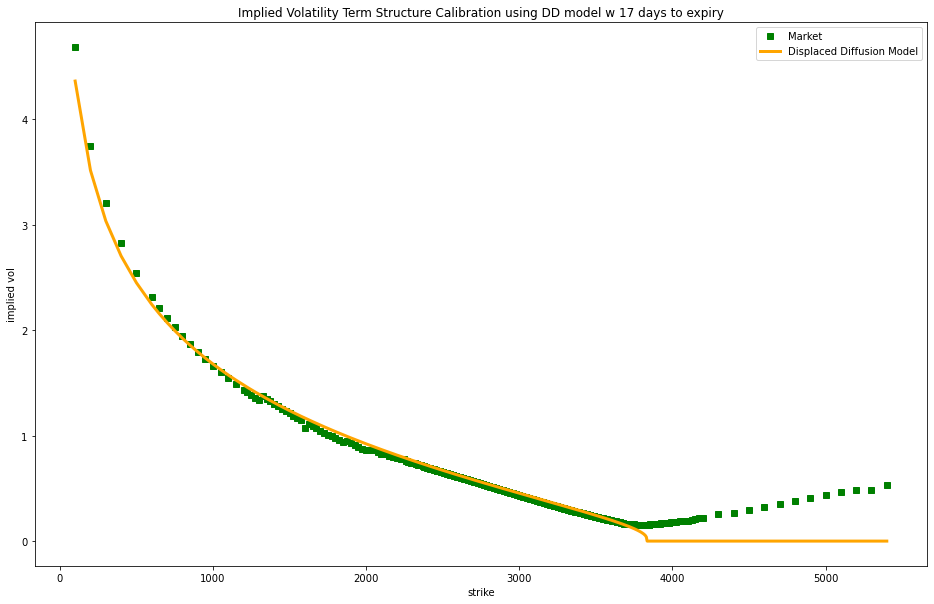

In [40]:
# 17 days to expiry

df = spx
exdate = spx['exdate'].unique()[0]
S = S_spx

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

# define Black76 Lognormal/Normal pricing functions
def Black76Lognormal(F, K, r, sigma, T, payoff):
    d1 = (log(F/K)+(0.5*(sigma**2)*T))/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    if payoff == 'call':
        return exp(-r*T)*(F*norm.cdf(d1) - K*norm.cdf(d2))
    if payoff == 'put':
        return exp(-r*T)*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DDVolatility(price, K, payoff):
    impliedVol = brentq(lambda x: price - \
                        Black76Lognormal(F, K, r, x, T, payoff), 1e-12, 100)
    return impliedVol

def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedVolatility(S, K, r, price, T, payoff):
    '''comparing market prices to BS prices to obtain implied vol'''
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

def Displaced_Diffusion(F, K, beta, r, sigma, T, payoff):
    Fd = F/beta
    Kd = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    d1 = (np.log(Fd/Kd) + (0.5*sigma_d**2)*T)/(sigma_d*np.sqrt(T))
    d2 = d1 - sigma_d*np.sqrt(T)
    
    if payoff == 'call': # call option
        call_value = Fd*np.exp(-r*T)*norm.cdf(d1) - Kd*np.exp(-r*T)*norm.cdf(d2)
        return call_value
    elif payoff == 'put': # put option
        put_value = -Fd*np.exp(-r*T)*norm.cdf(-d1) + Kd*np.exp(-r*T)*norm.cdf(-d2)
        return put_value

################# Calibration of Beta  #################################################
def Diffusioncalibration(beta1, strikes, vols, F, T):
    err = 0.0
    for i,vol in enumerate(vols):
        if strikes[i] >= F:
            payoff = 'call'
        if strikes[i] <= F:
            payoff = 'put'                     
        err +=(vol - DDVolatility(Displaced_Diffusion(F, strikes[i], beta1, r, ATMvol, T, payoff),
                                 strikes[i],
                                 payoff)
              )**2
    return err
    
beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df['strike'].values,
                                                      df['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in df.index:
    K = df.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

plt.figure(figsize = (16,10))
plt.plot(df['strike'],df['impliedvol'],'gs',label='Market')
plt.plot(df['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration using DD model w " + str(days_to_expiry) + " days to expiry")    
    
print('The calibrated parameter for Displaced-diffusion model w ' + str(days_to_expiry) + ': beta = ' + str(Diff_beta))

The calibrated parameter for Displaced-diffusion model w 45: beta = -9.98013667513738


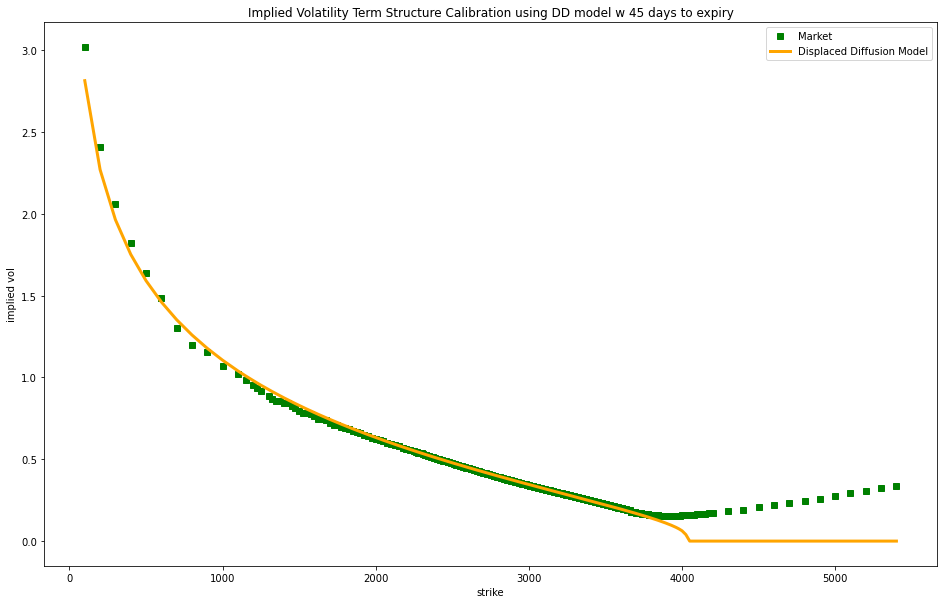

In [46]:
# 45 days to expiry

df = spx
exdate = spx['exdate'].unique()[1]
S = S_spx

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

################# Calibration of Beta  #################################################
    
beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df['strike'].values,
                                                      df['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in df.index:
    K = df.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

plt.figure(figsize = (16,10))
plt.plot(df['strike'],df['impliedvol'],'gs',label='Market')
plt.plot(df['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration using DD model w " + str(days_to_expiry) + " days to expiry")    
    
print('The calibrated parameter for Displaced-diffusion model w ' + str(days_to_expiry) + ': beta = ' + str(Diff_beta))

The calibrated parameter for Displaced-diffusion model w 80: beta = -6.28419318564363


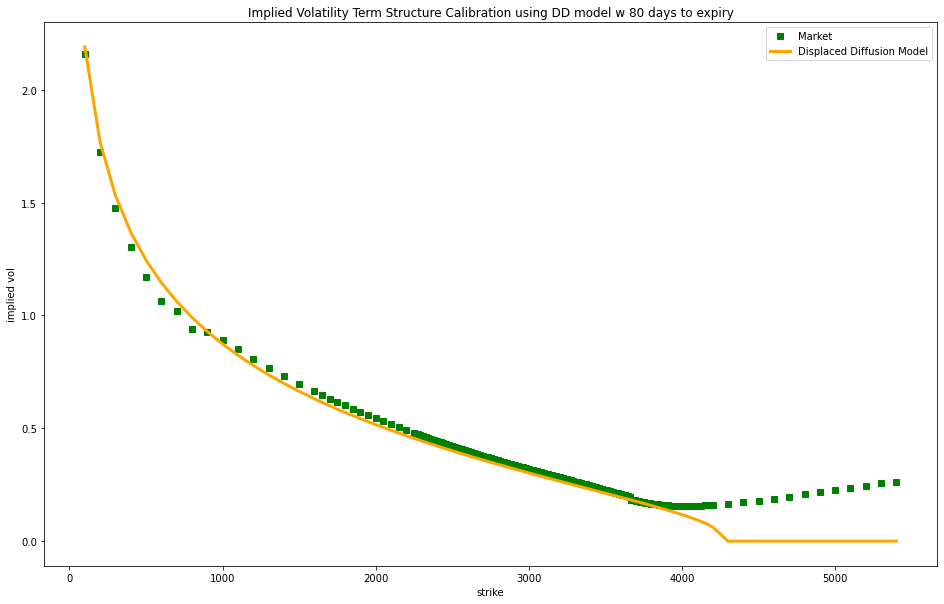

In [47]:
# 80 days to expiry

df = spx
exdate = spx['exdate'].unique()[2]
S = S_spx

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

################# Calibration of Beta  #################################################
    
beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df['strike'].values,
                                                      df['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in df.index:
    K = df.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

plt.figure(figsize = (16,10))
plt.plot(df['strike'],df['impliedvol'],'gs',label='Market')
plt.plot(df['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration using DD model w " + str(days_to_expiry) + " days to expiry")    
    
print('The calibrated parameter for Displaced-diffusion model w ' + str(days_to_expiry) + ': beta = ' + str(Diff_beta))

### SPY

The calibrated parameter for Displaced-diffusion model w 17: beta = -21.97234672282641


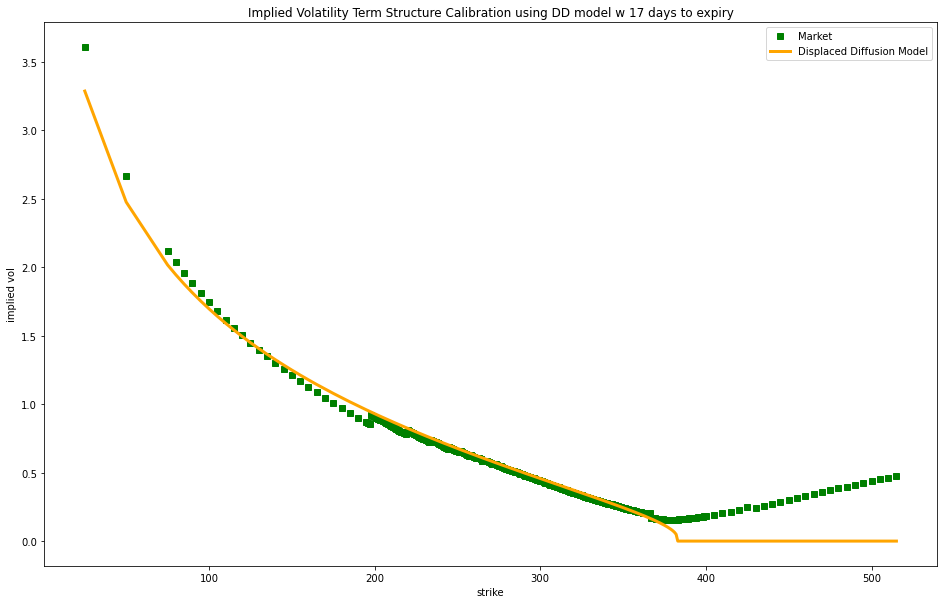

In [48]:
# 17 days to expiry

df = spy
exdate = spy['exdate'].unique()[0]
S = S_spy

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

################# Calibration of Beta  #################################################

beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df['strike'].values,
                                                      df['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in df.index:
    K = df.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

plt.figure(figsize = (16,10))
plt.plot(df['strike'],df['impliedvol'],'gs',label='Market')
plt.plot(df['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration using DD model w " + str(days_to_expiry) + " days to expiry")    
    
print('The calibrated parameter for Displaced-diffusion model w ' + str(days_to_expiry) + ': beta = ' + str(Diff_beta))

The calibrated parameter for Displaced-diffusion model w 45: beta = -11.097702293894107


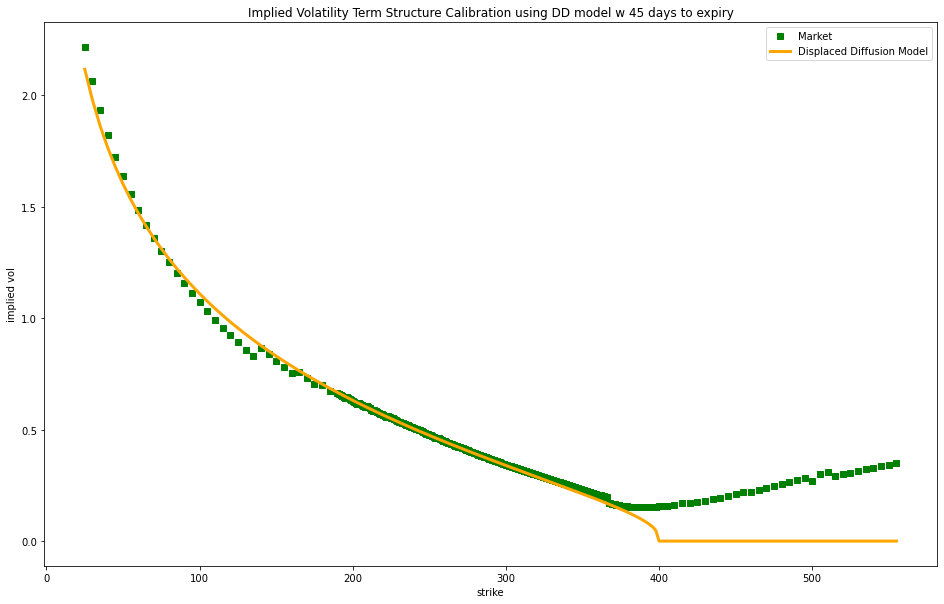

In [49]:
# 45 days to expiry

df = spy
exdate = spy['exdate'].unique()[1]
S = S_spy

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

################# Calibration of Beta  #################################################
    
beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df['strike'].values,
                                                      df['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in df.index:
    K = df.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

plt.figure(figsize = (16,10))
plt.plot(df['strike'],df['impliedvol'],'gs',label='Market')
plt.plot(df['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration using DD model w " + str(days_to_expiry) + " days to expiry")    
    
print('The calibrated parameter for Displaced-diffusion model w ' + str(days_to_expiry) + ': beta = ' + str(Diff_beta))

The calibrated parameter for Displaced-diffusion model w 80: beta = -6.762158203125001


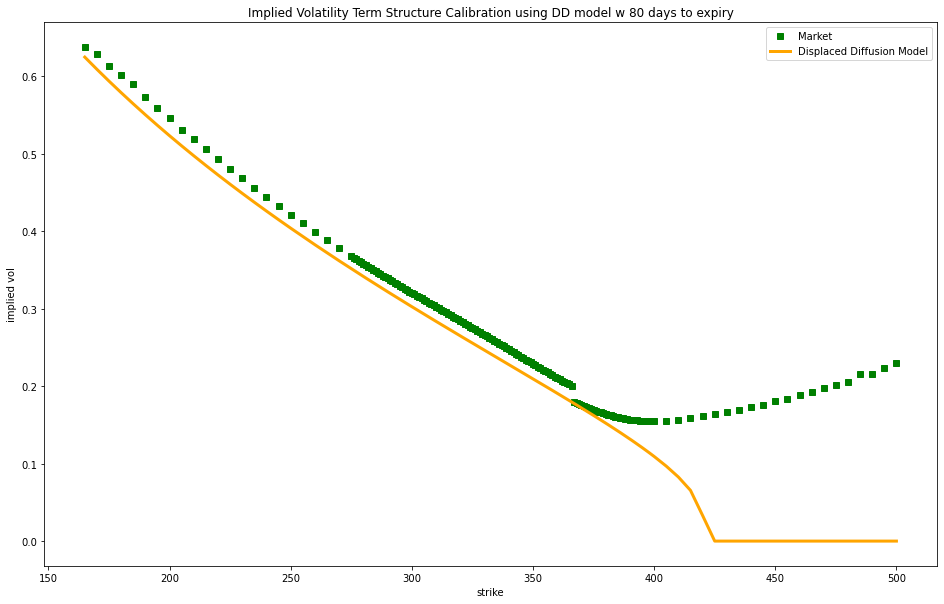

In [50]:
# 80 days to expiry

df = spy
exdate = spy['exdate'].unique()[2]
S = S_spy

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

################# Calibration of Beta  #################################################

beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df['strike'].values,
                                                      df['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in df.index:
    K = df.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

plt.figure(figsize = (16,10))
plt.plot(df['strike'],df['impliedvol'],'gs',label='Market')
plt.plot(df['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration using DD model w " + str(days_to_expiry) + " days to expiry")    
    
print('The calibrated parameter for Displaced-diffusion model w ' + str(days_to_expiry) + ': beta = ' + str(Diff_beta))

## Scenario 2:  Calibrated beta obtained from minimizing SSE between DD option price and market option price

### SPX

The calibrated parameter for Displaced-diffusion model: beta = -2.108238768577576


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (towards market prices) using DD model w 17 days to expiry')

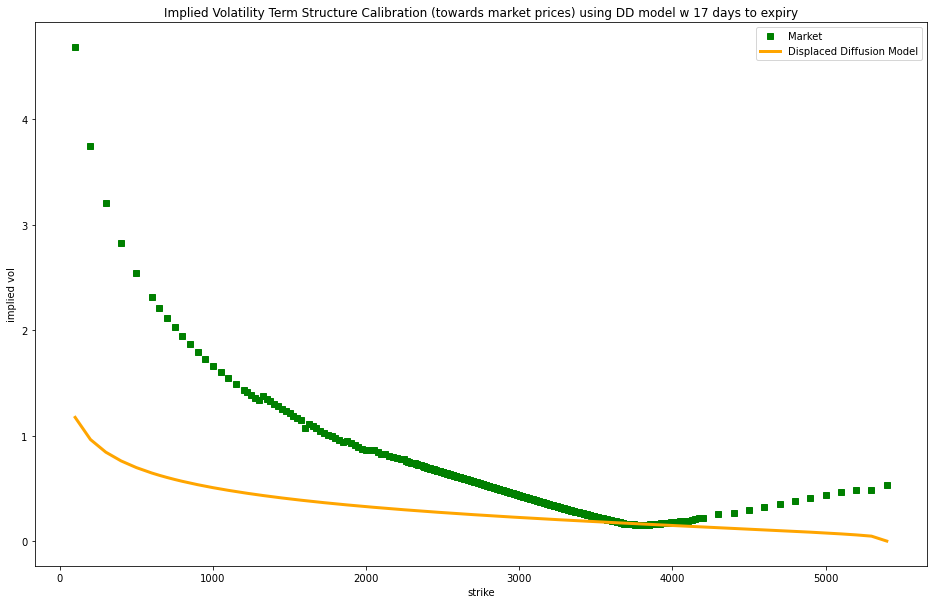

In [52]:
# 17 days to expiry

df = spx
exdate = spx['exdate'].unique()[0]
S = S_spx
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

################# Calibration of Beta  #################################################
def Diffusioncalibration_price(beta1, strikes, marketprice, F, T):
    err = 0.0
    for i,price in enumerate(marketprice):
        if strikes[i] >= F:
            payoff = 'call'
        if strikes[i] <= F:
            payoff = 'put'                     
        err +=(price - Displaced_Diffusion(F, strikes[i], beta1, r, ATMvol, T, payoff)
              )**2
    return err
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration_price(beta,
                                                      market['strike'].values,
                                                      market['marketprice'].values,
                                                      F, T), beta_guess
                   )
Diff_beta = res.x[0]
dd_price = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    dd_price.append(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff))
vol_dd = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(market['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (towards market prices) using DD model w " + str(days_to_expiry) + " days to expiry")

In [144]:
# # 45 days to expiry
# Disclaimer: We encounted an error saying there is inf values during the least_sqaures process, 
# and it persisted despite several different initial guess for beta were adopted
# Due to time constraint, we unfortunately are unable to resolve this issue and hence
# couldn't calibrate the DD model for this particular scenario for 45 days to expiry


# df = spx
# exdate = spx['exdate'].unique()[1]
# S = S_spx
# ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

# days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
# T = days_to_expiry/365
# r = ir_interpolate(days_to_expiry) / 100.0
# F = S*np.exp(r*T)

# df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
# df['strike'] = df['strike_price']*0.001 
# df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
# df = df[df['exdate'] == exdate]

# # implied vol for all strikes
# df['vols'] = df.apply(lambda x: impliedVolatility(S,
#                                                   x['strike'],
#                                                   r,
#                                                   x['mid'],
#                                                   T,
#                                                   x['payoff']),
#                       axis=1)

# df.dropna(inplace=True)
# call_df = df[df['payoff'] == 'call']
# put_df = df[df['payoff'] == 'put']
# strikes = put_df['strike'].values


# impliedvols = []
# marketprice = []
# for K in strikes:    
#     if K > S:
#         impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
#         marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
#     else:
#         impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
#         marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

# market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
# market.dropna(inplace = True)

# ################# Calibration of Beta  #################################################

# beta_guess = [-8]
# res = least_squares(lambda beta: Diffusioncalibration_price(beta,
#                                                       market['strike'].values,
#                                                       market['marketprice'].values,
#                                                       F, T), beta_guess
#                    )
# Diff_beta = res.x[0]
# dd_price = []
# for i in market.index:
#     K = market.loc[i]['strike']
#     if K >= F: # call
#         payoff = 'call'
#     if K <= F:  # put
#         payoff = 'put'
#     dd_price.append(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff))
# vol_dd = []
# for i in market.index:
#     K = market.loc[i]['strike']
#     if K >= F: # call
#         payoff = 'call'
#     if K <= F:  # put
#         payoff = 'put'
#     vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

# print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

# plt.figure(figsize = (16,10))
# plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
# plt.plot(market['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
# plt.legend()
# plt.xlabel('strike')
# plt.ylabel('implied vol')
# plt.title("Implied Volatility Term Structure Calibration (towards market prices) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -2.111062005162239


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (towards market prices) using DD model w 80 days to expiry')

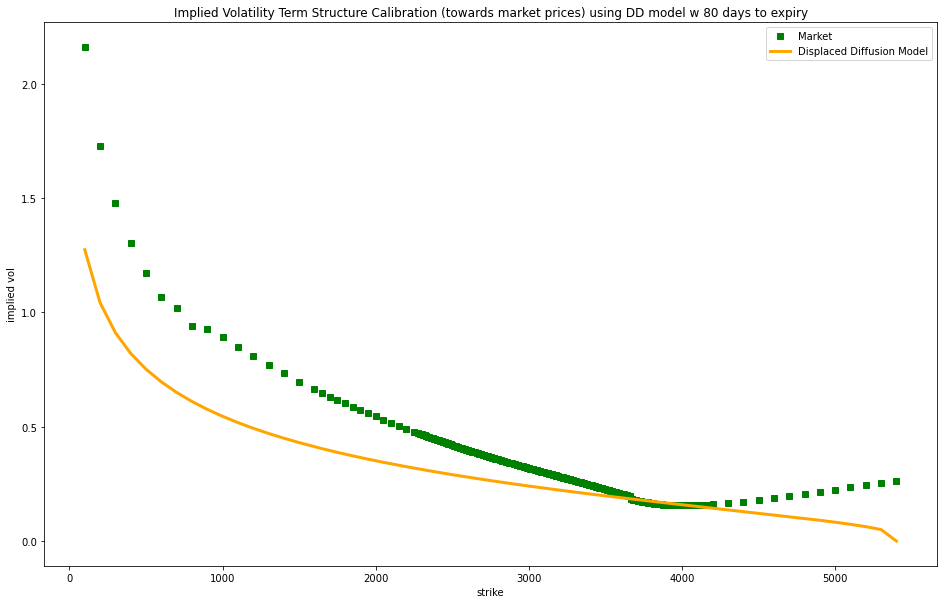

In [65]:
# 80 days to expiry

df = spx
exdate = spx['exdate'].unique()[2]
S = S_spx
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

################# Calibration of Beta  #################################################

beta_guess = [-2]
res = least_squares(lambda beta: Diffusioncalibration_price(beta,
                                                      market['strike'].values,
                                                      market['marketprice'].values,
                                                      F, T), beta_guess
                   )
Diff_beta = res.x[0]
dd_price = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    dd_price.append(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff))
vol_dd = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(market['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (towards market prices) using DD model w " + str(days_to_expiry) + " days to expiry")

### SPY

The calibrated parameter for Displaced-diffusion model: beta = -2.457377290725707


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (towards market prices) using DD model w 17 days to expiry')

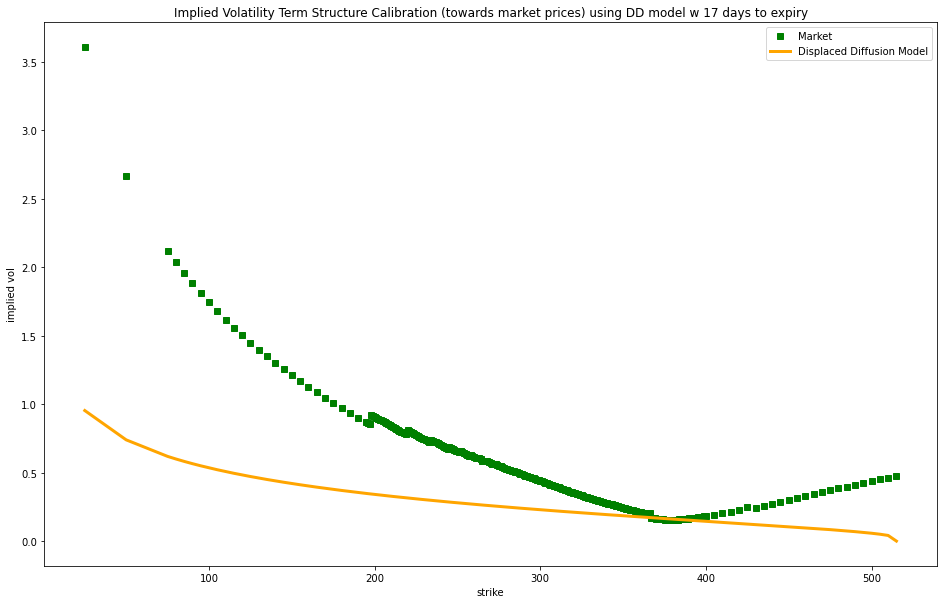

In [59]:
# 17 days to expiry

df = spy
exdate = spy['exdate'].unique()[0]
S = S_spy
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

################# Calibration of Beta  #################################################

beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration_price(beta,
                                                      market['strike'].values,
                                                      market['marketprice'].values,
                                                      F, T), beta_guess
                   )
Diff_beta = res.x[0]
dd_price = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    dd_price.append(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff))
vol_dd = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(market['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (towards market prices) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -1.9382126569747926


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (towards market prices) using DD model w 45 days to expiry')

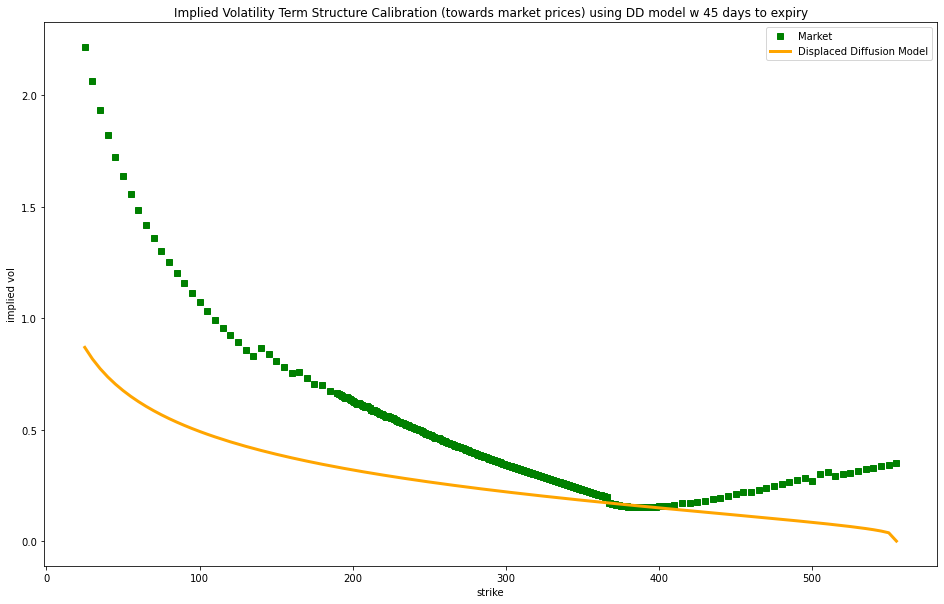

In [60]:
# 45 days to expiry

df = spy
exdate = spy['exdate'].unique()[1]
S = S_spy
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

################# Calibration of Beta  #################################################

beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration_price(beta,
                                                      market['strike'].values,
                                                      market['marketprice'].values,
                                                      F, T), beta_guess
                   )
Diff_beta = res.x[0]
dd_price = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    dd_price.append(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff))
vol_dd = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(market['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (towards market prices) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -2.7369408845901497


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (towards market prices) using DD model w 80 days to expiry')

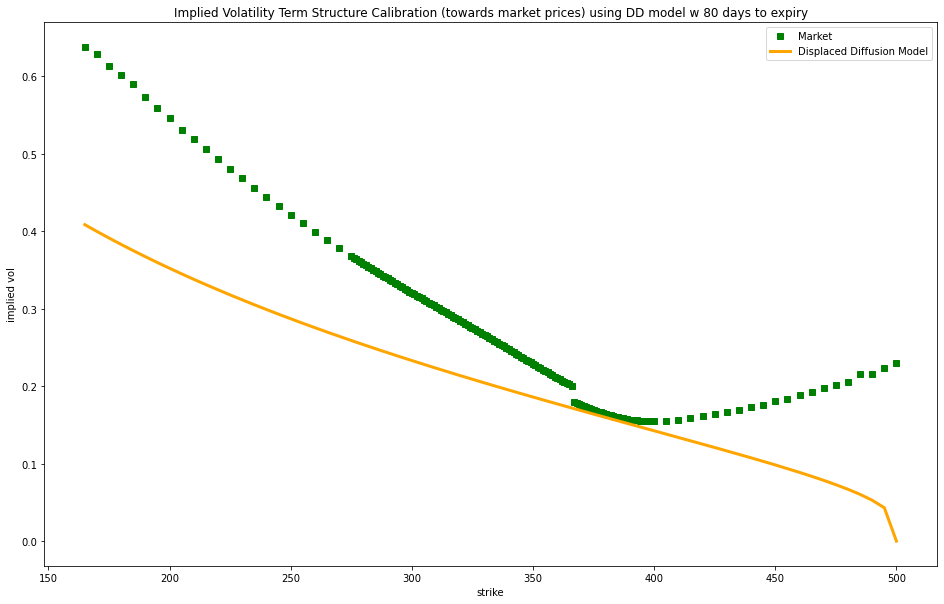

In [61]:
# 80 days to expiry

df = spy
exdate = spy['exdate'].unique()[2]
S = S_spy
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

################# Calibration of Beta  #################################################

beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration_price(beta,
                                                      market['strike'].values,
                                                      market['marketprice'].values,
                                                      F, T), beta_guess
                   )
Diff_beta = res.x[0]
dd_price = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    dd_price.append(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff))
vol_dd = []
for i in market.index:
    K = market.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))

print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(market['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (towards market prices) using DD model w " + str(days_to_expiry) + " days to expiry")

## Scenario 3: Calibrated beta obtained from truncating payoff (narrowing the range of strikes to reduce skew in IV plot) and then minimizing SSE between DD IV and market IV

### SPX

In [134]:
# 17 days to expiry

df = spx
exdate = spx['exdate'].unique()[0]
S = S_spx
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

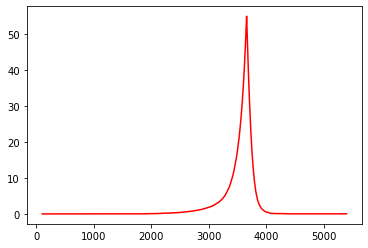

In [108]:
plt.plot(market['strike'], market['marketprice'], 'r-')

The calibrated parameter for Displaced-diffusion model: beta = -8.256626905438338


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w 17 days to expiry')

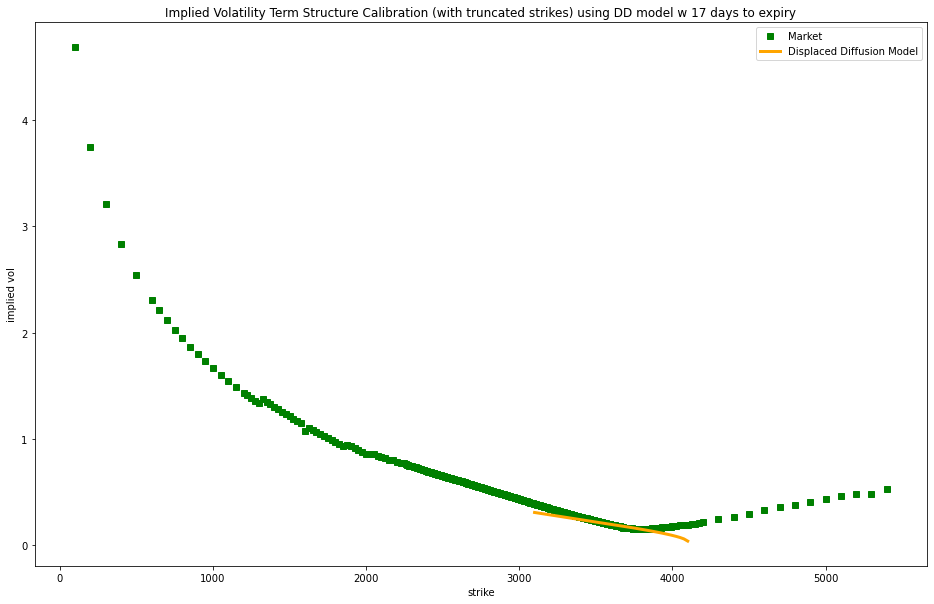

In [139]:
# truncate far OTM options for calibration
truncated = (market[market.strike >= 3100])[market.strike <= 4100]

################# Calibration of Beta  #################################################
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      truncated['strike'].values,
                                                      truncated['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in truncated.index:
    K = truncated.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))
    
print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(truncated['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -6.621875000000002


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w 45 days to expiry')

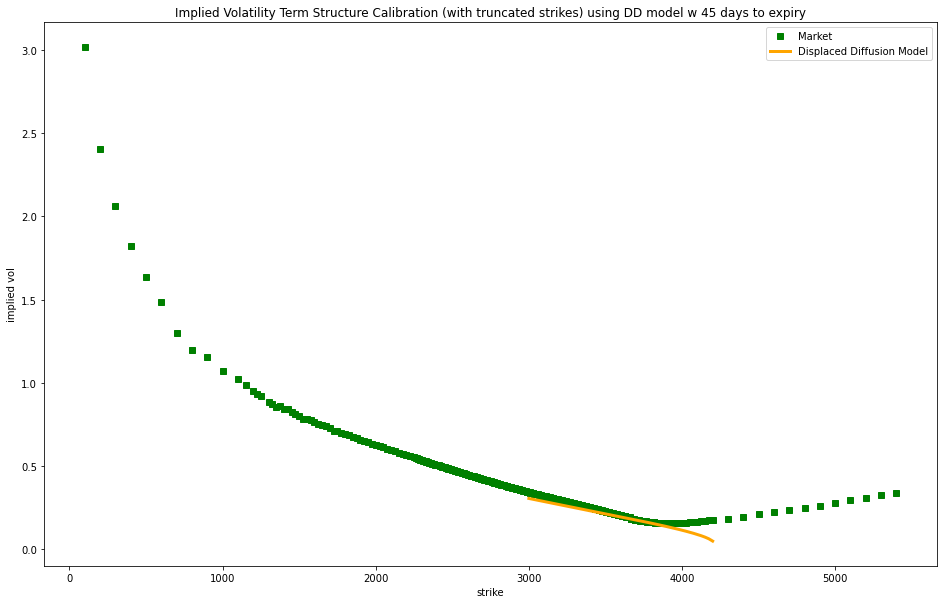

In [141]:
# 45 days to expiry

df = spx
exdate = spx['exdate'].unique()[1]
S = S_spx
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

# truncate far OTM options for calibration
truncated = (market[market.strike >= 3000])[market.strike <= 4200]

################# Calibration of Beta  #################################################
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      truncated['strike'].values,
                                                      truncated['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in truncated.index:
    K = truncated.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))
    
print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(truncated['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -5.643579895945295


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w 80 days to expiry')

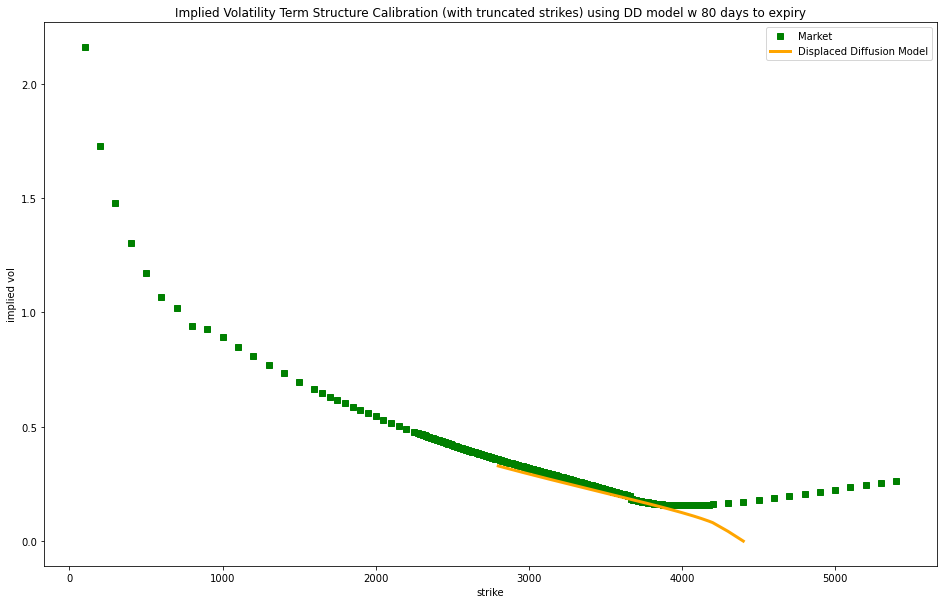

In [133]:
# 80 days to expiry

df = spx
exdate = spx['exdate'].unique()[2]
S = S_spx
ATMvol = ATMVols.loc[str(days_to_expiry)]['spx_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

# truncate far OTM options for calibration
truncated = (market[market.strike >= 2800])[market.strike <= 4400]

################# Calibration of Beta  #################################################
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      truncated['strike'].values,
                                                      truncated['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in truncated.index:
    K = truncated.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))
    
print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(truncated['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w " + str(days_to_expiry) + " days to expiry")

### SPY

In [130]:
# 17 days to expiry

df = spy
exdate = spy['exdate'].unique()[0]
S = S_spy
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

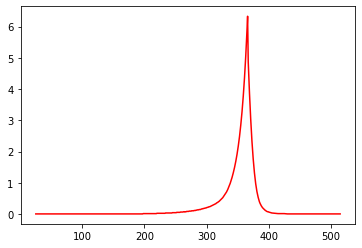

In [103]:
plt.plot(market['strike'], market['marketprice'], 'r-')

The calibrated parameter for Displaced-diffusion model: beta = -9.3487060546875


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w 17 days to expiry')

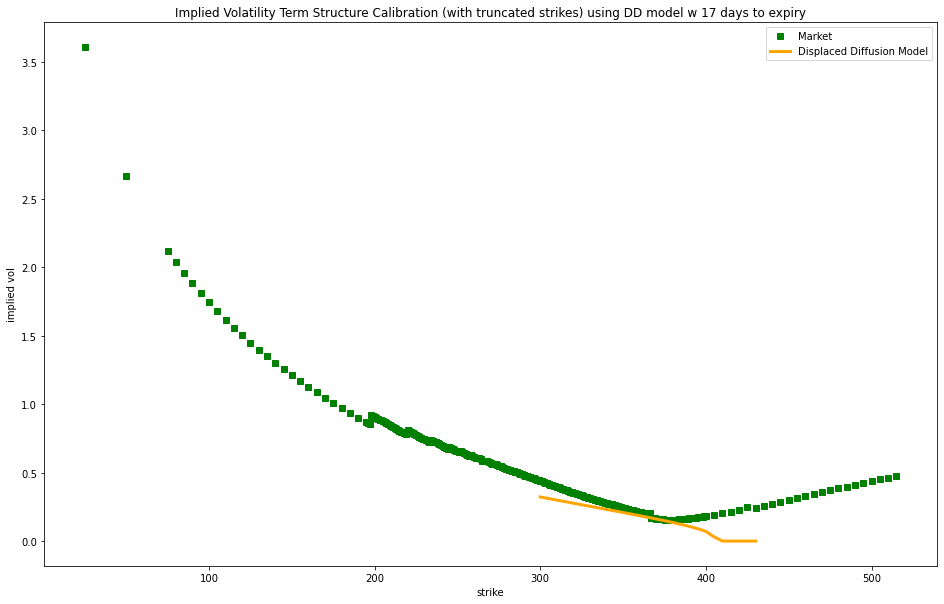

In [131]:
# truncate far OTM options for calibration
truncated = (market[market.strike >= 300])[market.strike <= 430]

################# Calibration of Beta  #################################################
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      truncated['strike'].values,
                                                      truncated['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in truncated.index:
    K = truncated.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))
    
print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(truncated['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -5.514660644531251


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w 45 days to expiry')

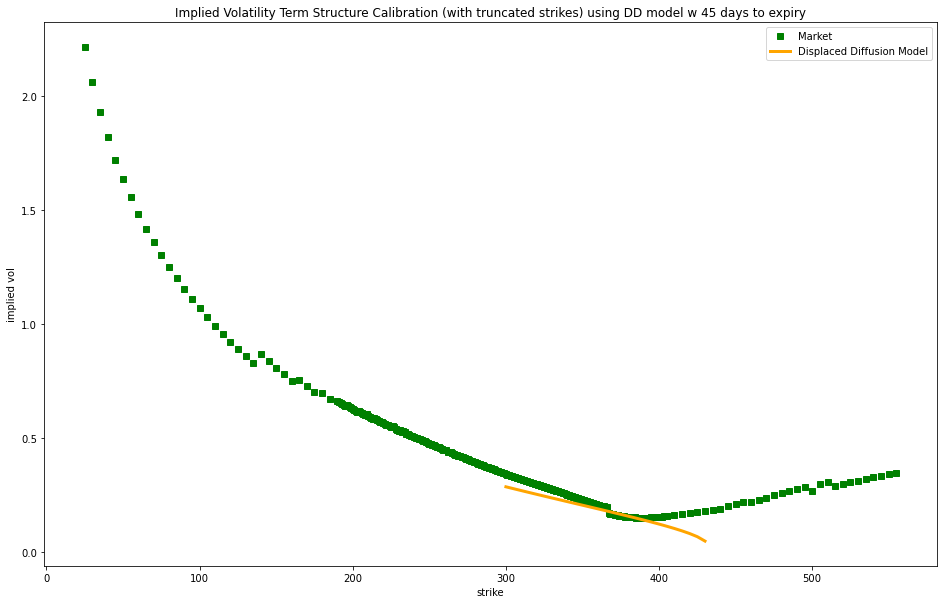

In [129]:
# 45 days to expiry

df = spy
exdate = spy['exdate'].unique()[1]
S = S_spy
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

# truncate far OTM options for calibration
truncated = (market[market.strike >= 300])[market.strike <= 430]

################# Calibration of Beta  #################################################
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      truncated['strike'].values,
                                                      truncated['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in truncated.index:
    K = truncated.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))
    
print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(truncated['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w " + str(days_to_expiry) + " days to expiry")

The calibrated parameter for Displaced-diffusion model: beta = -5.3631835937500005


Text(0.5, 1.0, 'Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w 80 days to expiry')

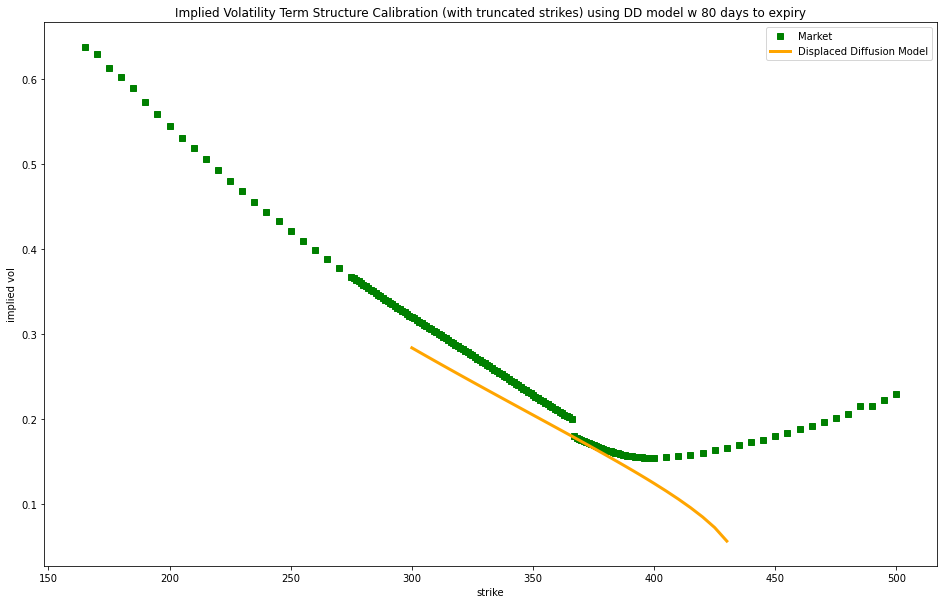

In [128]:
# 80 days to expiry

df = spy
exdate = spy['exdate'].unique()[2]
S = S_spy
ATMvol = ATMVols.loc[str(days_to_expiry)]['spy_call']

days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
r = ir_interpolate(days_to_expiry) / 100.0
F = S*np.exp(r*T)

df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001 
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df = df[df['exdate'] == exdate]

# implied vol for all strikes
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)

df.dropna(inplace=True)
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
strikes = put_df['strike'].values


impliedvols = []
marketprice = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0]) 
        marketprice.append(call_df[call_df['strike'] == K]['mid'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        marketprice.append(put_df[put_df['strike'] == K]['mid'].values[0])

market = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols, 'marketprice': marketprice})
market.dropna(inplace = True)

# truncate far OTM options for calibration
truncated = (market[market.strike >= 300])[market.strike <= 430]

################# Calibration of Beta  #################################################
    
beta_guess = [0.2]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      truncated['strike'].values,
                                                      truncated['impliedvol'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]
vol_dd = []
for i in truncated.index:
    K = truncated.loc[i]['strike']
    if K >= F: # call
        payoff = 'call'
    if K <= F:  # put
        payoff = 'put'
    vol_dd.append(DDVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, payoff), K, payoff))
    
print('The calibrated parameter for Displaced-diffusion model: beta = ' + str(Diff_beta))

plt.figure(figsize = (16,10))
plt.plot(market['strike'],market['impliedvol'],'gs',label='Market')
plt.plot(truncated['strike'],vol_dd,'orange',linewidth=3, label='Displaced Diffusion Model')
plt.legend()
plt.xlabel('strike')
plt.ylabel('implied vol')
plt.title("Implied Volatility Term Structure Calibration (with truncated strikes) using DD model w " + str(days_to_expiry) + " days to expiry")

## End of Part 2